Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 04-January-2026

In [1]:
# Import libraries 
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import cmocean

In [2]:
# Settings 
data_dir = r'../data/'
syn_thresh = 5

In [3]:
# Load connectivity 
df_connectivity = pd.read_csv(data_dir + 'flywire_v783_connections.csv')
df_connectivity = df_connectivity.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")

# Load neuron classifications 
df_class = pd.read_csv(data_dir + 'flywire_v783_classifications.csv')

# Load neurotransmitter information 
df_nt = pd.read_csv(data_dir + 'flywire_v783_neurotransmitters.csv') # neuron.csv

# Load neurons of interest
df_neurons_of_interest = pd.read_csv(data_dir + 'neurons_of_interest.csv')

In [4]:
# Set target neurons
dict_nodes = {}
dict_nodes['RRN'] = df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name=='RRN'].tolist() 
dict_nodes['BPN'] = df_neurons_of_interest.connectome_id[df_neurons_of_interest.community_name.str.contains('BPN')].tolist()
    
target_nodes = list(itertools.chain(*list(dict_nodes.values())))

In [5]:
# Trim connectivity datatframe
df_connectivity = df_connectivity[df_connectivity['post_root_id'].isin(target_nodes)]

In [6]:
# Sum synapses across neuropils
df_connectivity = df_connectivity.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)

In [7]:
# Remove connections between neurons smaller than syn_thresh 
df_connectivity = df_connectivity[df_connectivity.syn_count>=syn_thresh]

In [8]:
# Get partner nodes
partner_nodes = df_connectivity['pre_root_id'].unique().tolist()

In [9]:
# Neuropil dictionary
dict_neuropils = {
        'LA': 'OL',
        'ME': 'OL',
        'AME': 'OL',
        'LO': 'OL',
        'LOP': 'OL',
        'MB': 'MB', 
        'MB_CA': 'MB',
        'MB_PED': 'MB',
        'SPU': 'MB',
        'MB_VL': 'MB',
        'MB_ML': 'MB',
        'FB': 'CX',
        'EB': 'CX',
        'PB': 'CX',
        'NO': 'CX',
        'BU': 'LX',
        'LAL': 'LX',
        'GA': 'LX',
        'AOTU': 'VLNP',
        'VLP': 'VLNP',
        'AVLP': 'VLNP',
        'PVLP': 'VLNP',
        'PLP': 'VLNP',
        'WED': 'VLNP',
        'LH': 'LH',
        'SLP': 'SNP',
        'SIP': 'SNP',
        'SMP': 'SNP',
        'CRE': 'INP',
        'CL': 'INP',
        'SCL': 'INP',
        'ICL': 'INP',
        'IB': 'INP',
        'ATL': 'INP',
        'AL': 'AL',
        'VX': 'VMNP',
        'VES': 'VMNP',
        'EPA': 'VMNP',
        'GOR': 'VMNP',
        'PS': 'VMNP',
        'SPS': 'VMNP',
        'IPS': 'VMNP',
        'AMMC': 'PENP',
        'SAD': 'PENP',
        'FLA': 'PENP',
        'CAN': 'PENP',
        'PRW': 'PENP',
        'GNG': 'GNG',
        'nan': 'UNASGD',
        'UNASGD': 'UNASGD'}

In [10]:
# Generate dataframe with relative synapse counts per neuropil for each presynaptic neuron 
df_neuropil = pd.DataFrame()

# Reload full conectivity
df_neuropil = pd.read_csv(data_dir + 'flywire_v783_connections.csv')
df_neuropil = df_neuropil.rename(columns={"pre_pt_root_id": "pre_root_id", "post_pt_root_id": "post_root_id"}, errors="raise")

# Trim connectivity datatframe
df_neuropil = df_neuropil[df_neuropil['post_root_id'].isin(partner_nodes)]

# Remove connections between neurons smaller than syn_thresh 
df_neuropil_summed = df_neuropil.groupby(['pre_root_id','post_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_neuropil_summed = df_neuropil_summed[df_neuropil_summed.syn_count>=syn_thresh]
pre_root_ids_to_keep = df_neuropil_summed.pre_root_id.tolist()
post_root_ids_to_keep = df_neuropil_summed.post_root_id.tolist()

df_neuropil = df_neuropil[(df_neuropil.pre_root_id.isin(pre_root_ids_to_keep)) & (df_neuropil.pre_root_id.isin(post_root_ids_to_keep))]


# Generate list of neuropil names with _L and _R
neuropil_names_merged = df_neuropil.neuropil.to_list()
for ix, i in enumerate(neuropil_names_merged):
    if pd.isnull(i):
        neuropil_names_merged[ix] = 'UNASGD'
    elif '_' in i:
        neuropil_names_merged[ix] = i[:-(len(i)-i.find('_'))] 

# Replace neuropil names 
df_neuropil['neuropil'] = pd.Series(neuropil_names_merged).values
df_neuropil.reset_index(drop=True, inplace=True)

# Sum entries where neuropil is the same (merge synapse counts of left and right hemisphere) 
df_neuropil = df_neuropil.groupby(['post_root_id','neuropil'])['syn_count'].sum().reset_index()
df_neuropil = df_neuropil.rename(columns={"post_root_id": "root_id"}, errors="raise")


# Compute relative synapse counts
df_synapse_counts = df_neuropil.groupby(['root_id'])['syn_count'].sum().reset_index()

rel_syn_count = []
for _ , row in df_neuropil.iterrows():
    rel_syn_count.append(row.syn_count / (df_synapse_counts.syn_count[df_synapse_counts.root_id == row.root_id].item()))

df_neuropil["rel_syn_count"] = rel_syn_count

In [11]:
# Generate connectivity matrix with relative synapse counts from presynaptic neuropils
neuropils = list(dict_neuropils.keys())
conn_mat_neuropils = np.zeros([len(target_nodes),len(neuropils)])

for target_index, target_node in enumerate(target_nodes):
    df_connectivity_target = df_connectivity[df_connectivity.post_root_id == target_node] 

    for _ , target_row in df_connectivity_target.iterrows():
        df_neuropil_target = df_neuropil[df_neuropil.root_id == target_row.pre_root_id]

        for _ , neuropil_row in df_neuropil_target.iterrows():
            neuropil_index = neuropils.index(neuropil_row.neuropil)
    
            conn_mat_neuropils[target_index][neuropil_index] += target_row.syn_count*neuropil_row.rel_syn_count

In [12]:
# Sum and normalize connectivity matrix per neuron type
conn_mat_neuropils_summed = np.zeros((2,np.size(conn_mat_neuropils,axis=1)))
conn_mat_neuropils_summed[0][:] = np.sum(conn_mat_neuropils[:len(dict_nodes['RRN'])][:], axis=0)
conn_mat_neuropils_summed[0][:] = conn_mat_neuropils_summed[0][:] / np.sum(conn_mat_neuropils_summed[0][:])
conn_mat_neuropils_summed[1][:] = np.sum(conn_mat_neuropils[len(dict_nodes['RRN']):][:], axis=0)
conn_mat_neuropils_summed[1][:] = conn_mat_neuropils_summed[1][:] / np.sum(conn_mat_neuropils_summed[1][:])

In [13]:
# Exclude neuropils with value zero
columns_to_include = (np.sum(conn_mat_neuropils_summed,axis=0) > 0)
columns_to_include = [i for i, x in enumerate(columns_to_include) if x]

neuropils = [neuropil for index, neuropil in enumerate(neuropils) if index in columns_to_include]
conn_mat_neuropils_summed = conn_mat_neuropils_summed[:,columns_to_include]

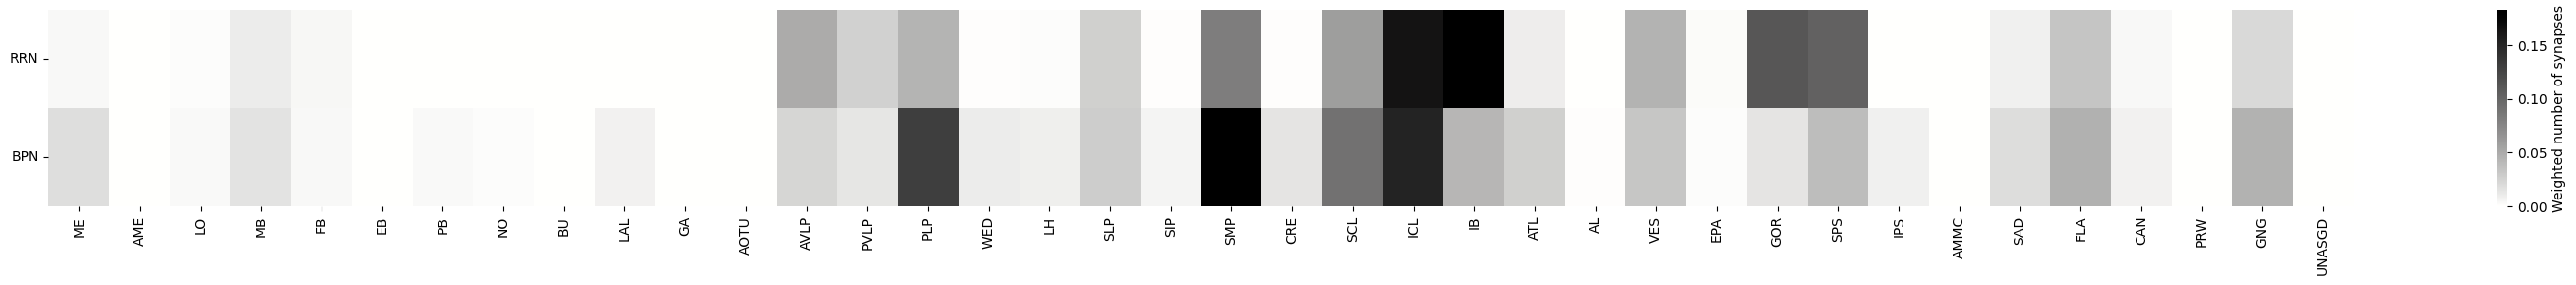

In [14]:
# Plot connectivity with neuropils 
fig = plt.figure(figsize=(30,3))
cmap = cmocean.cm.gray_r

xticklabels = neuropils
yticklabels = list(dict_nodes.keys())
        
sns.heatmap(conn_mat_neuropils_summed, 
            cmap = cmap, 
            xticklabels = xticklabels, 
            yticklabels = yticklabels,
            cbar_kws = {'label': 'Weighted number of synapses'})
            
plt.yticks(rotation=0)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

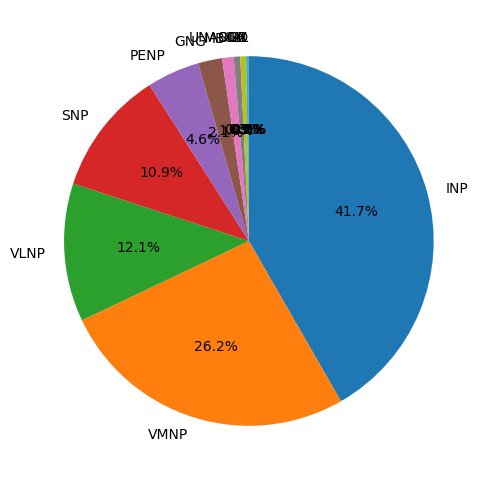

In [15]:
# Plot pie chart of summed inputs from neuropil classes
target = 0 # 0 (RRN), 1 (BPN)

# Sum weighted synapses per neuropil class
dict_neuropil_counts = {"OL": 0, "MB": 0, "CX": 0, "LX": 0, "VLNP": 0, "LH": 0, "SNP": 0, "INP": 0, "AL": 0, "VMNP": 0, "PENP": 0, "GNG": 0, "UNASGD": 0}

count = 0
for index, neuropil in enumerate(neuropils):
    neuropil_class = dict_neuropils[neuropil]
    dict_neuropil_counts[neuropil_class] += conn_mat_neuropils_summed[target][index] 

sorted_items = sorted(dict_neuropil_counts.items(), key=lambda item: item[1], reverse=True)

# Separate keys (labels) and values (sizes)
labels = [item[0] for item in sorted_items]
sizes = [item[1] for item in sorted_items]

# Create pie chart
plt.figure(figsize=(8, 6)) 
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
plt.show()